<a href="https://colab.research.google.com/github/sridevibonthu/EVA/blob/master/S9/S9_Quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Date and Time


In [1]:
import datetime 
print("Current Date/Time: ", datetime.datetime.now())


Current Date/Time:  2020-03-17 14:50:45.420494


# Import Libraries

In [2]:
# mount the drive where we will save stats and loade our libraries from
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [4]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)


[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4')

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
import numpy as np
import eva4datatransforms
from torchvision import transforms
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
trans = eva4datatransforms.Transforms(normalize=True, mean=channel_means, stdev=channel_stdevs)
fillmeans = (np.array(channel_means)*255).astype(np.uint8)
# Train Phase transformations
train_transforms = trans.train_transforms([
                                       transforms.RandomRotation((-15.0, 15.0), fill=tuple(fillmeans)),
                                       transforms.RandomHorizontalFlip(),
                                       ], 
                                       
                                       [transforms.RandomErasing(value = tuple(channel_means))])

# Test Phase transformations
test_transforms = trans.test_transforms()

In [8]:
tuple(fillmeans)

(125, 122, 113)

# Dataset and Creating Train/Test Split

In [9]:

from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 3, 32, 32])
torch.Size([128])


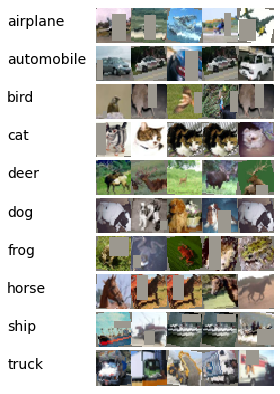

In [11]:
from __future__ import print_function
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))
  #return np.transpose(img, (1, 2, 0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [12]:
import eva4models
import QuizDNN
import torch
model = QuizDNN.QuizNet()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]           2,048
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

# Let's Train and test our model

In [13]:
#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 15
L2lambda = 0
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True, L1lambda)

Validation loss decreased (100000.000000 --> 1.921001).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0108, Accuracy: 49.30%; Test set: Average loss: 1.9210, Accuracy: 44.12%
Learning Rate = 0.076211


Validation loss decreased (1.921001 --> 1.270998).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0082, Accuracy: 62.56%; Test set: Average loss: 1.2710, Accuracy: 57.36%
Learning Rate = 0.218512


Validation loss decreased (1.270998 --> 0.857247).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0070, Accuracy: 68.17%; Test set: Average loss: 0.8572, Accuracy: 70.75%
Learning Rate = 0.380247


Epoch: 4, Train set: Average loss: 0.0062, Accuracy: 72.19%; Test set: Average loss: 1.1654, Accuracy: 63.31%
Learning Rate = 0.485656


Validation loss decreased (0.857247 --> 0.663889).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0056, Accuracy: 74.82%; Test set: Average loss: 0.6639, Accuracy: 77.88%
Learning Rate = 0.497179


Epoch: 6, Train set: Average loss: 0.0052, Accuracy: 76.78%; Test set: Average loss: 0.7302, Accuracy: 76.51%
Learning Rate = 0.475159


Validation loss decreased (0.663889 --> 0.601090).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0048, Accuracy: 78.35%; Test set: Average loss: 0.6011, Accuracy: 79.60%
Learning Rate = 0.433133


Validation loss decreased (0.601090 --> 0.552489).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0045, Accuracy: 79.80%; Test set: Average loss: 0.5525, Accuracy: 81.87%
Learning Rate = 0.374835


Validation loss decreased (0.552489 --> 0.506578).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0043, Accuracy: 80.96%; Test set: Average loss: 0.5066, Accuracy: 82.77%
Learning Rate = 0.305444


Validation loss decreased (0.506578 --> 0.477245).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0040, Accuracy: 82.13%; Test set: Average loss: 0.4772, Accuracy: 83.66%
Learning Rate = 0.231128


Validation loss decreased (0.477245 --> 0.406318).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0037, Accuracy: 83.22%; Test set: Average loss: 0.4063, Accuracy: 86.27%
Learning Rate = 0.158488


Validation loss decreased (0.406318 --> 0.386159).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0035, Accuracy: 84.47%; Test set: Average loss: 0.3862, Accuracy: 87.18%
Learning Rate = 0.093980


Validation loss decreased (0.386159 --> 0.350399).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0032, Accuracy: 85.56%; Test set: Average loss: 0.3504, Accuracy: 88.42%
Learning Rate = 0.043334


Validation loss decreased (0.350399 --> 0.333679).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0029, Accuracy: 87.03%; Test set: Average loss: 0.3337, Accuracy: 88.82%
Learning Rate = 0.011052


Validation loss decreased (0.333679 --> 0.329260).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0027, Accuracy: 87.80%; Test set: Average loss: 0.3293, Accuracy: 89.07%
Learning Rate = 0.000002

